In [1]:
%matplotlib widget
import numpy as np
import caiman as cm
import matplotlib.pyplot as plt
from caiman.motion_correction import MotionCorrect
from caiman.source_extraction.cnmf import cnmf
from caiman.source_extraction.cnmf.params import CNMFParams
from caiman.utils.visualization import view_quilt
import pandas as pd

In [2]:
fname = "../data/Sue_2x_3000_40_-46.tif"
movie_orig = cm.load(fname)

In [3]:
# motion correction
params = CNMFParams()
motion_params = {
    'strides': (48, 48),
    'overlaps': (24, 24),
    'max_shifts': (6, 6),
    'max_deviation_rigid': 3,
    'pw_rigid': True
}
params.motion.update(motion_params)
mc = MotionCorrect(fname, **params.motion)
mc.motion_correct(save_movie=True)
mc.fname_tot_els

['../data\\Sue_2x_3000_40_-46_els__d1_170_d2_170_d3_1_order_F_frames_3000.mmap']

In [4]:
mc_fname = cm.save_memmap(
    mc.fname_tot_els,
    base_name='memmap_',
    order='C'
)

In [5]:
Yr, dims, num_frames = cm.load_memmap(mc_fname)
images = np.reshape(Yr.T, [num_frames] + list(dims), order='F')
images.shape

(3000, 170, 170)

In [6]:
patch_params = {
    "rf": 15,
    "stride": 10,
    'gSig': 4,
    'K': 7    
}
params.patch.update(patch_params)
cnmf_model = cnmf.CNMF(n_processes=1, params=params)

In [7]:
cnmf_fit = cnmf_model.fit(images)

In [8]:
cnmf_refit = cnmf_fit.refit(images)

In [9]:
movie_corrected = cm.load(mc.mmap_file) # load motion corrected movie
correlation_image = cm.local_correlations(movie_corrected, swap_dim=False)

100%|██████████| 1/1 [00:00<00:00,  4.45it/s]


In [10]:
print("Thresholds to be used for evaluate_components()")
print(f"min_SNR = {cnmf_refit.params.quality['min_SNR']}")
print(f"rval_thr = {cnmf_refit.params.quality['rval_thr']}")
print(f"min_cnn_thr = {cnmf_refit.params.quality['min_cnn_thr']}")

Thresholds to be used for evaluate_components()
min_SNR = 2.5
rval_thr = 0.8
min_cnn_thr = 0.9


In [11]:
cnmf_refit.estimates.evaluate_components(images, cnmf_refit.params);


GPU run not requested, disabling use of GPUs
USING MODEL (keras API): C:\Users\sangeetha\caiman_data\model\cnn_model.json
51/51 [==============================] - 1s 13ms/step


In [12]:
print(f"Num accepted/rejected: {len(cnmf_refit.estimates.idx_components)}, {len(cnmf_refit.estimates.idx_components_bad)}")

Num accepted/rejected: 59, 1569


In [13]:
cnmf_refit.estimates.plot_contours_nb(img=correlation_image, 
                                      idx=cnmf_refit.estimates.idx_components);

In [16]:
cnmf_refit.estimates.nb_view_components(img=correlation_image, 
                                        idx=cnmf_refit.estimates.idx_components,
                                        cmap='gray',
                                        denoised_color='red');

In [15]:
cnmf_refit.estimates.nb_view_components(img=correlation_image, 
                                        idx=cnmf_refit.estimates.idx_components_bad, 
                                        cmap='gray',
                                        denoised_color='red')

delta F/F

In [17]:
cnmf_refit.estimates.detrend_df_f(quantileMin=8, 
                                    frames_window=250,
                                    flag_auto=False,
                                    use_residuals=False); 

In [ ]:
cnmf_refit.estimates.nb_view_components(img=correlation_image, 
                                        idx=cnmf_refit.estimates.idx_components,
                                        cmap='gray',
                                        denoised_color='red');

In [20]:
frame_rate = cnmf_refit.params.data['fr']
frame_pd = 1/frame_rate
frame_times = np.linspace(0, num_frames*frame_pd, num_frames);

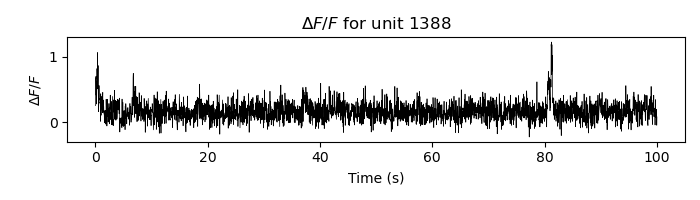

In [23]:
idx_to_plot = 30
idx_accepted = cnmf_refit.estimates.idx_components
component_number = idx_accepted[idx_to_plot]
f, ax = plt.subplots(figsize=(7,2))
ax.plot(frame_times, 
        cnmf_refit.estimates.F_dff[component_number, :], 
        linewidth=0.5,
        color='k');
ax.set_xlabel('Time (s)')
ax.set_ylabel('$\Delta F/F$')
ax.set_title(f"$\Delta F/F$ for unit {component_number}");
plt.tight_layout()